# Logistic Regression

In [1]:
import pandas as pd

# Path to data file
parquet_file_path = '../../Costa_Rica_Data/Data Acquisition Output/extracted_gee_data/en_clean_gee_data.parquet'

# Load into a DataFrame
df = pd.read_parquet(parquet_file_path)

# Display head
df.head()

,plotid,sampleid,Use,CoverType,Vegetations,Herbaceous,GrasslandShrub,CropsType,WetlandArea,LandType,...,mTPI,ndvi,ocs_1mMed,sand_1mMed,savi,silt_1mMed,slope,topDiv,wetness,Forest_Presence
9,2902,11605,Wetlands,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,8129.0,0.799771,68.0,332.15,0.393728,298.85,0.927410,1323.685053,-0.006312,Present
12,2902,11608,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),Not_Applicable,Not_Applicable,Not_Applicable,...,8129.0,0.796553,68.0,332.15,0.423713,298.85,2.935819,1323.685053,-0.014932,Present
13,2902,11609,Wetlands,Vegetation,Herbaceous plants,Grasses,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,8129.0,0.644415,65.0,340.45,0.380250,304.70,0.944368,1323.685053,-0.001697,Present
15,2902,11611,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),Not_Applicable,Not_Applicable,Not_Applicable,...,8129.0,0.784331,68.0,332.15,0.512687,298.85,0.927410,1323.685053,-0.027987,Present
16,2902,11612,Wetlands,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,8129.0,0.769357,65.0,340.45,0.360428,304.70,2.645556,1323.685053,-0.009912,Present


In [2]:
y = df['Use']  # Set the target variable
X = df[['BLUE','GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'aspect',
       'aspectcos', 'aspectdeg', 'brightness', 'clay_1mMed',
       'diff', 'elevation', 'evi', 'fpar', 'hand30_100', 'lai', 'mTPI', 'ndvi',
       'ocs_1mMed', 'sand_1mMed', 'savi', 'slope', 'topDiv',
       'wetness']]  # Predictor features

In [3]:
# Check for class imbalance
print("Class distribution:")
print(y.value_counts(normalize=True))

Class distribution:
Use
Forest               0.573300
Grasslands           0.237094
Agriculture          0.084957
Other classes        0.051481
Wetlands             0.039808
Forest plantation    0.009117
No information       0.002383
Not_Applicable       0.001860
Name: proportion, dtype: float64


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Create a pipeline for logistic regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Include scaling in the pipeline
    ('logistic', LogisticRegression(max_iter=1000, random_state=42))
])

# Cross-validation

In [7]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# Splits our data into 5 folds, training on 4 parts and testing on 1
cv_scores = cross_val_score(
    logistic_pipeline, X_train_scaled, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy' # use stratified folds to keep class balance in each split
)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation scores: [0.72013327 0.71632556 0.71754947 0.7246022  0.71834625]
Mean CV accuracy: 0.7194 ± 0.0029


# Hyperparameter tuning with GridSearchCV

In [8]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

# Create a grid of different model settings to try for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],      # Inverse of regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'], # Regularization type
    'solver': ['saga'],                 # Only solver that supports all penalties
    'l1_ratio': [0.5],                  # Only used when penalty='elasticnet'
    'max_iter': [1000]                  # Increase iterations for convergence
}

# GridSearchCV tries all possible combinations
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=StratifiedKFold(n_splits=3),
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)
grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

c:\Users\samue\miniconda3\envs\mlenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best parameters: {'C': 10, 'l1_ratio': 0.5, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation accuracy: 0.7188


c:\Users\samue\miniconda3\envs\mlenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
# Train model with best parameters
best_logistic = grid_search.best_estimator_
best_logistic.fit(X_train, y_train)

c:\Users\samue\miniconda3\envs\mlenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\samue\miniconda3\envs\mlenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=10, l1_ratio=0.5, max_iter=1000, random_state=42,
                   solver='saga')

In [10]:
# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = best_logistic.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.6544
Classification Report:
                   precision    recall  f1-score   support

      Agriculture       0.50      0.20      0.29      1562
           Forest       0.75      0.90      0.82     10539
Forest plantation       0.00      0.00      0.00       168
       Grasslands       0.44      0.46      0.45      4359
   No information       0.00      0.00      0.00        44
   Not_Applicable       0.00      0.00      0.00        34
    Other classes       0.56      0.11      0.19       946
         Wetlands       0.29      0.11      0.16       732

         accuracy                           0.65     18384
        macro avg       0.32      0.22      0.24     18384
     weighted avg       0.62      0.65      0.62     18384



c:\Users\samue\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samue\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samue\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


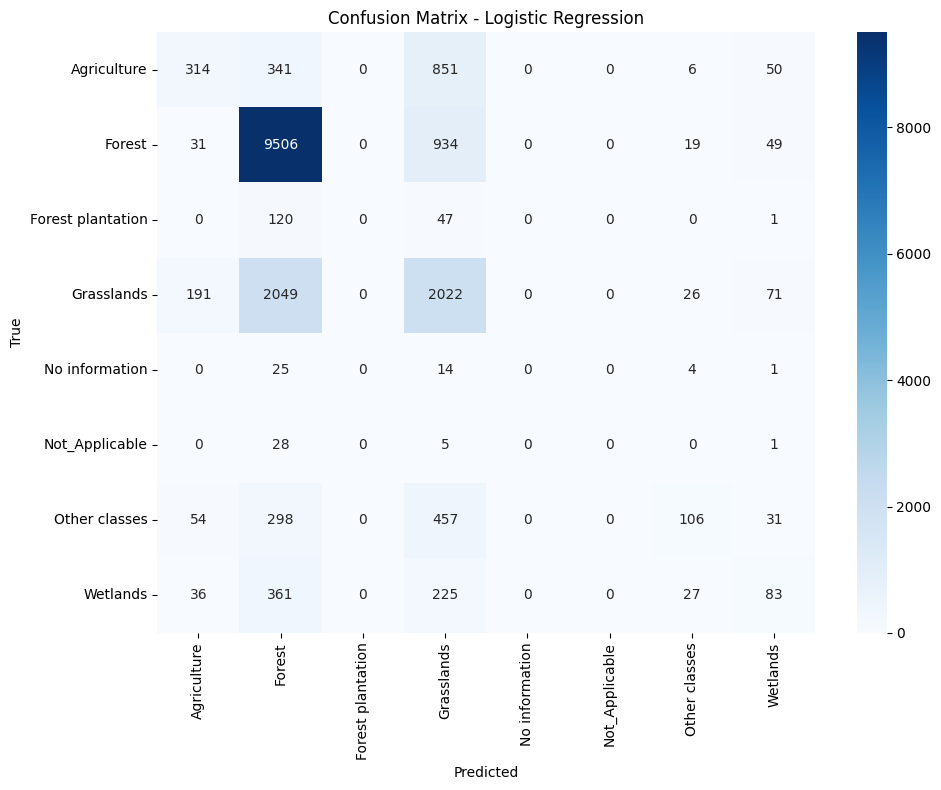

In [11]:
# Confusion Matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

# PCA

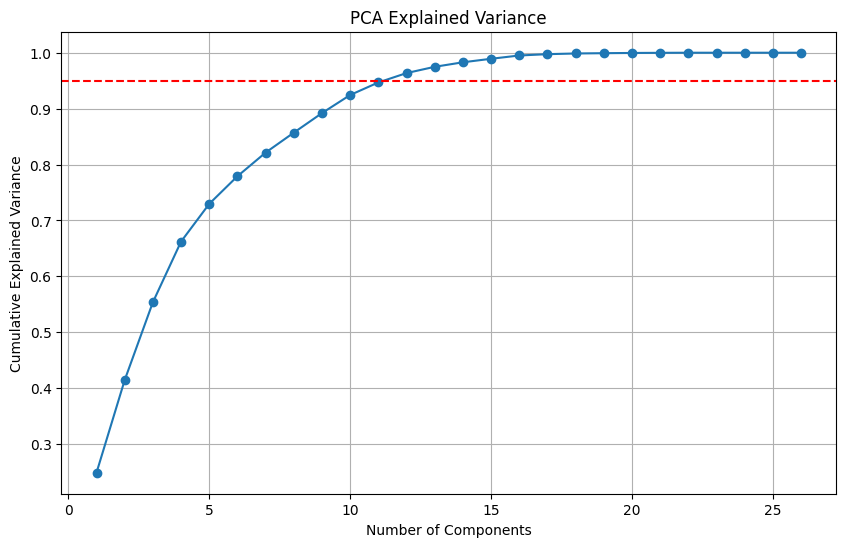

In [12]:
from sklearn.decomposition import PCA
# PCA finds the components where our data varies the most
# Helps decide how many features we actually need to keep
pca = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()
# X-axis: number of components used
# Y-axis: percentage of total variance explained
# Red line: 95% variance threshold
# Blue line: Shows how quickly we capture information as we add more components

In [13]:
# Determine number of components for 95% variance
n_components = np.where(cumulative_variance >= 0.95)[0][0] + 1
print(f"Number of components for 95% variance: {n_components}") # From 26 -> 12

Number of components for 95% variance: 12


In [14]:
# Create a pipeline with PCA and Logistic Regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Get the best parameters from grid search
best_params = grid_search.best_params_.copy()

# Remove l1_ratio if penalty is not 'elasticnet'
if 'l1_ratio' in best_params and best_params.get('penalty') != 'elasticnet':
    del best_params['l1_ratio']

# Update max_iter in the parameters dictionary
best_params['max_iter'] = 2000

# Build pipeline combining PCA with Logistic Regression
pca_lr_pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('lr', LogisticRegression(**best_params, random_state=42))
])

# Train the pipeline on the scaled training data
pca_lr_pipeline.fit(X_train_scaled, y_train)

# Evaluate on test data
pca_lr_accuracy = pca_lr_pipeline.score(X_test_scaled, y_test)
print(f"PCA + LR Test Accuracy: {pca_lr_accuracy:.4f}")

PCA + LR Test Accuracy: 0.7082


In [15]:
print(f"Standard LR Test Accuracy: {accuracy:.4f}")

Standard LR Test Accuracy: 0.6544


In [ ]:
# Save the model
# import joblib
# joblib.dump(best_logistic, 'best_logistic_model.pkl')
# print("Logistic Regression model saved as 'best_logistic_model.pkl'")

Logistic Regression model saved as 'best_logistic_model.pkl'
